In [ ]:
import pandas as pd
import numpy as np

# Graphing
from graph_config import plt


import tqdm as tqdm

from pathlib import Path
import sys

NOTEBOOK_PATH = Path(__file__).resolve() if '__file__' in globals() else Path().resolve()

PROJECT_ROOT = NOTEBOOK_PATH.parent

# Define path to the dataset folder
RAW_DATASET = PROJECT_ROOT / '01_datasets'/'raw'
PROCESSED_DATASET = PROJECT_ROOT / '01_datasets'/'processed'

# Define path to output folder
FIGURES_PATH = PROJECT_ROOT / '04_outputs' / '01_figures'
TABLES_PATH = PROJECT_ROOT / '04_outputs' / '02_tables'

# Script paths
SCRIPTS_PATH = PROJECT_ROOT / '03_scripts'


In [46]:
def load_data(filename):
    return pd.read_csv(RAW_DATASET / filename)

df_tt = load_data('Turbine_telemetry.csv')
df_rd = load_data('Residential_demand.csv')
df_wd = load_data('kirkwall_weather.csv')

df_rd['Timestamp'] = pd.to_datetime(df_rd['Timestamp'])
df_rd['Timestamp'] = pd.to_datetime(df_rd['Timestamp'])

df_tt_original = df_tt.copy()

print(f"turbine telemetry shape: {df_tt.shape}")
print(f"residential demand shape: {df_rd.shape}")
print(f"weather data shape: {df_wd.shape}")

turbine telemetry shape: (1069636, 4)
residential demand shape: (17568, 3)
weather data shape: (16584, 9)


# Cleaning Turbine Telemetry Data

## Removing Data Points Where Wind Speed Is Fast Enough But No Power

In [48]:
# Find the minimum wind speed for power production
v_min = df_tt[(df_tt.loc[:, 'Power_kw'] >= 10.)].loc[:, 'Wind_ms'].quantile(0.1) # 10% quantile minimum speed

print(f"minimum wind speed for power production: {v_min:.2f} m/s")

# Select only rows with Setpoint_kw == 900
df_tt = df_tt.query('Setpoint_kw==900').copy()

# remove data points when the wind speed is fast enough for power production but there is no power; turbine is probably manually switched off here
df_tt.loc[
    (df_tt['Wind_ms'] >= v_min) & (df_tt['Power_kw'].abs() <= 1e-5),
    'Power_kw'
] = np.nan

df_tt[df_tt.isna().any(axis=1)]
# # remove all missing values from the dataframe
# # df_tt.dropna(inplace=True)

# # Convert timestamp to datetime
# df_tt['Timestamp'] = pd.to_datetime(df_tt['Timestamp'])

# # Clip the power to the setpoint 900 kW
# df_tt['Power_kw'] = df_tt['Power_kw'].clip(upper=900)

# print(f"turbine telemetry data shape: {df_tt.shape}")

# df_tt.head()

minimum wind speed for power production: 4.90 m/s


Timestamp  Power_kw  Setpoint_kw  Wind_ms
2844     2015-05-29 23:24:23       NaN        900.0     10.4
20177    2015-12-14 21:32:43       NaN        900.0      NaN
20183    2015-12-14 21:37:43       NaN        900.0      NaN
24445    2015-12-19 19:06:49       NaN        900.0      8.5
24446    2015-12-19 19:07:49       NaN        900.0      7.6
...                      ...       ...          ...      ...
1043642  2017-12-24 02:12:32       NaN        900.0      6.5
1043643  2017-12-24 02:13:32       NaN        900.0      7.5
1043644  2017-12-24 02:14:32       NaN        900.0      5.1
1044974  2017-12-25 00:24:32       NaN        900.0      8.1
1050615  2017-12-29 00:24:32       NaN        900.0      6.1

[14179 rows x 4 columns]

In [49]:
df_tt_timeindex = df_tt.copy()

# Set the timestamp as index 
df_tt_timeindex['Timestamp'] = pd.to_datetime(df_tt_timeindex['Timestamp'])

df_tt_timeindex = df_tt_timeindex.set_index('Timestamp')

# Resample the data to 30-minute intervals
df_tt_resampled = df_tt_timeindex.resample('30min').mean()

# Select the data for the year 2017
df_tt_resampled_2017 = df_tt_resampled[
    (df_tt_resampled.index >= '2017-01-01') &
    (df_tt_resampled.index < '2018-01-02')
]


In [50]:
#check nan values in resampled data
df_tt_resampled_2017.isna().sum()

Power_kw       1865
Setpoint_kw    1826
Wind_ms        1826
dtype: int64

## Clean Resampled

In [5]:
df_tt_resampled['Month'] = df_tt_resampled.index.to_period('M')
df_tt_resampled['Month_int'] = df_tt_resampled['Month'].dt.month
df_tt_resampled['Year_int'] = df_tt_resampled.index.to_period('Y').year

df_tt_resampled.head()

Power_kw  Setpoint_kw    Wind_ms    Month  Month_int  \
Timestamp                                                                     
2015-05-28 00:00:00  103.000000        900.0   5.533333  2015-05          5   
2015-05-28 00:30:00  204.000000        900.0   7.040000  2015-05          5   
2015-05-28 01:00:00  285.600000        900.0   7.876667  2015-05          5   
2015-05-28 01:30:00  457.266667        900.0   9.166667  2015-05          5   
2015-05-28 02:00:00  890.133333        900.0  12.973333  2015-05          5   

                     Year_int  
Timestamp                      
2015-05-28 00:00:00      2015  
2015-05-28 00:30:00      2015  
2015-05-28 01:00:00      2015  
2015-05-28 01:30:00      2015  
2015-05-28 02:00:00      2015

## Clean Original Timeseries

In [6]:
df_tt['Month'] = df_tt['Timestamp'].dt.to_period('M')
df_tt['Month_int'] = df_tt['Month'].dt.month
df_tt['Year_int'] = df_tt['Timestamp'].dt.year

df_tt.head()

Timestamp  Power_kw  Setpoint_kw  Wind_ms    Month  Month_int  \
0 2015-05-28 00:00:23      80.0        900.0      4.9  2015-05          5   
1 2015-05-28 00:01:23      78.0        900.0      5.4  2015-05          5   
2 2015-05-28 00:02:23      52.0        900.0      4.9  2015-05          5   
3 2015-05-28 00:03:23      57.0        900.0      4.6  2015-05          5   
4 2015-05-28 00:04:23      54.0        900.0      4.6  2015-05          5   

   Year_int  
0      2015  
1      2015  
2      2015  
3      2015  
4      2015

# Scraped Weather Data Cleaning

In [ ]:
# df_wd[df_wd['Timestamp'].dt.date >= pd.to_datetime('2017-01-22').date()].head(20)

#select non numeric values from wind speed column
# Convert to numeric, coercing errors to NaN
converted = pd.to_numeric(df_wd['Wind Speed (m/s)'], errors='coerce')

# Mask where the original value is a string and conversion failed (i.e., it's not a valid number)
mask = converted.isna() & df_wd['Wind Speed (m/s)'].apply(lambda x: isinstance(x, str))

# Display the problematic string values
df_wd.loc[mask, 'Wind Speed (m/s)'].unique()

array(['No wind'], dtype=object)

In [88]:
df_wd = load_data(RAW_DATASET/'kirkwall_weather.csv')
# Cleaning weather data
df_wd = df_wd.rename(columns={'Time': 'Timestamp'})
# Convert timestamp to datetime
df_wd['Timestamp'] = pd.to_datetime(df_wd['Timestamp'])

# Sort value based on timestamp
df_wd = df_wd.sort_values('Timestamp').reset_index(drop=True)

# aligning timestamp 00:20 into 00:30 and 00:50 to 01:00
df_wd['Timestamp'] = df_wd.Timestamp.apply(lambda x: x + pd.Timedelta(minutes=10))

# df_wd['Wind Speed (m/s)'] = pd.to_numeric(df_wd['Wind Speed (m/s)'], errors='coerce').fillna(0.0)


print(f"Weather scrape columns: {df_wd.columns}")
df_wd.head()

# df_wd.to_csv(PROCESSED_DATASET / 'kirkwall_weather_cleaned.csv', index=False)

# resample to 30 mminutes
df_wd_timeindex = df_wd.copy()
# Set the timestamp as index
# Convert 'Timestamp' column to datetime before setting index
df_wd_timeindex['Timestamp'] = pd.to_datetime(df_wd_timeindex['Timestamp'])

df_wd_timeindex = df_wd_timeindex.set_index('Timestamp')

#convert wind speed to numeric
df_wd_timeindex['Wind Speed (m/s)'] = pd.to_numeric(
    df_wd_timeindex['Wind Speed (m/s)'],
    errors='coerce'
).fillna(0) 

df_wd_timeindex = df_wd_timeindex[~df_wd_timeindex.index.duplicated(keep='first')]

# Select only numeric columns for resampling
df_wd_resampled = df_wd_timeindex.select_dtypes(include='number').resample('30min').mean()

# Reset the index so 'Timestamp' becomes a column again
df_wd_resampled_reset = df_wd_resampled.reset_index()

# Save to CSV
df_wd_resampled_reset.to_csv(PROCESSED_DATASET/'df_wd_resampled.csv', index=False)



Weather scrape columns: Index(['Timestamp', 'Icon', 'Temperature (F)', 'Description',
       'Wind Speed (m/s)', 'Wind Direction', 'Humidity (%)', 'Pressure (Hg)',
       'Visibility (mi)'],
      dtype='object')


In [90]:
is_nan = df_wd_resampled['Wind Speed (m/s)'].isna()
wind_is_nan = df_wd_resampled['Wind Speed (m/s)'].isna()

start_mask = is_nan & ~is_nan.shift(1, fill_value=False)
end_mask = is_nan & ~is_nan.shift(-1, fill_value=False)

start_times = df_wd_resampled.index[start_mask]
end_times = df_wd_resampled.index[end_mask]

nan_ranges_df = pd.DataFrame({
    'Start': start_times,
    'End': end_times
})

nan_ranges_df['Duration'] = nan_ranges_df['End'] - nan_ranges_df['Start']

nan_ranges_df.sort_values(by='Start', inplace=True)

nan_ranges_df.head(10)

Start                 End        Duration
0 2017-01-01 05:30:00 2017-01-01 12:00:00 0 days 06:30:00
1 2017-01-03 12:00:00 2017-01-03 12:00:00 0 days 00:00:00
2 2017-01-04 03:30:00 2017-01-04 03:30:00 0 days 00:00:00
3 2017-01-04 18:00:00 2017-01-04 18:00:00 0 days 00:00:00
4 2017-01-08 12:30:00 2017-01-08 12:30:00 0 days 00:00:00
5 2017-01-09 00:30:00 2017-01-09 00:30:00 0 days 00:00:00
6 2017-01-11 08:30:00 2017-01-11 08:30:00 0 days 00:00:00
7 2017-01-11 09:30:00 2017-01-11 09:30:00 0 days 00:00:00
8 2017-01-12 18:30:00 2017-01-12 18:30:00 0 days 00:00:00
9 2017-01-13 06:00:00 2017-01-13 06:00:00 0 days 00:00:00

In [ ]:
2017-01-23 17:00:00

In [95]:
df_wd[df_wd['Timestamp'] >= pd.to_datetime('2017-01-23 16:00:00')].head(10)


Timestamp             Icon  Temperature (F)      Description  \
1062 2017-01-23 16:00:00  Passing clouds.               41  Passing clouds.   
1063 2017-01-23 16:30:00  Passing clouds.               41  Passing clouds.   
1064 2017-01-23 18:00:00  Passing clouds.               41  Passing clouds.   
1065 2017-01-23 18:30:00  Passing clouds.               39  Passing clouds.   
1066 2017-01-23 19:00:00  Passing clouds.               39  Passing clouds.   
1067 2017-01-23 19:30:00  Passing clouds.               41  Passing clouds.   
1068 2017-01-23 20:00:00          Chilly.               39          Chilly.   
1069 2017-01-23 20:30:00          Chilly.               39          Chilly.   
1070 2017-01-23 21:00:00          Chilly.               39          Chilly.   
1071 2017-01-23 21:30:00          Chilly.               39          Chilly.   

     Wind Speed (m/s)                                     Wind Direction  \
1062             4.02              Wind blowing from 190° South to North   
1063             5.81              Wind blowing from 190° South to North   
1064             6.71              Wind blowing from 180° South to North   
1065             6.26              Wind blowing from 190° South to North   
1066             6.71  Wind blowing from 200° South-southwest to Nort...   
1067             5.36  Wind blowing from 200° South-southwest to Nort...   
1068             4.02              Wind blowing from 190° South to North   
1069             4.47              Wind blowing from 190° South to North   
1070             5.36              Wind blowing from 180° South to North   
1071             4.47              Wind blowing from 180° South to North   

      Humidity (%)  Pressure (Hg)  Visibility (mi)  
1062          87.0          30.09              NaN  
1063          87.0          30.09              NaN  
1064          81.0          30.07              NaN  
1065          87.0          30.07              NaN  
1066          87.0          30.07              NaN  
1067          87.0          30.07              NaN  
1068          87.0          30.04              NaN  
1069          93.0          30.04              NaN  
1070          87.0          30.04              NaN  
1071          87.0          30.01              NaN

## Join TT with Scraped Data

In [57]:
df_tt_resampled_2017 = df_tt_resampled_2017.reset_index()

# inner join resample 2017 turbine telemetry data with weather data  
df_tt_wd = pd.merge(
    df_wd[['Timestamp', 'Wind Speed (m/s)']],
    df_tt_resampled_2017[['Timestamp', 'Wind_ms', 'Power_kw']],
    how='inner',
    on='Timestamp'
)

# Rename columns for clarity
df_tt_wd = df_tt_wd.rename(columns={
    'Wind Speed (m/s)': 'Wind_speed_scraped',
    'Wind_ms': 'Wind_speed_baseline',
    'Power_kw': 'Power_baseline'
})

# Ensure Timestamp is a datetime
df_tt_wd['Timestamp'] = pd.to_datetime(df_tt_wd['Timestamp'])

# Create a 'Month' column for grouping
df_tt_wd['Month'] = df_tt_wd['Timestamp'].dt.to_period('M')
df_tt_wd['Month_int'] = df_tt_wd['Month'].dt.month


# Show result
df_tt_wd.head()


Timestamp  Wind_speed_scraped  Wind_speed_baseline  \
0 2017-01-01 00:30:00               10.28            16.106667   
1 2017-01-01 01:00:00                9.39            16.380000   
2 2017-01-01 01:30:00                9.83            17.083333   
3 2017-01-01 02:00:00                7.15            16.800000   
4 2017-01-01 02:30:00                8.94            18.021739   

   Power_baseline    Month  Month_int  
0      893.266667  2017-01          1  
1      897.633333  2017-01          1  
2      899.966667  2017-01          1  
3      900.000000  2017-01          1  
4      899.956522  2017-01          1

In [ ]:
df_tt_w

# Scrape-Demand Analysis

In [26]:
df_wd.head(20)

Timestamp                                  Icon  Temperature (F)  \
0  2017-01-01 00:30:00                       Passing clouds.               41   
1  2017-01-01 01:00:00                           Quite cool.               43   
2  2017-01-01 01:30:00                       Passing clouds.               41   
3  2017-01-01 02:00:00                       Passing clouds.               39   
4  2017-01-01 02:30:00                       Passing clouds.               41   
5  2017-01-01 03:00:00                       Passing clouds.               41   
6  2017-01-01 03:30:00                       Passing clouds.               39   
7  2017-01-01 04:00:00                       Passing clouds.               41   
8  2017-01-01 04:30:00                       Passing clouds.               39   
9  2017-01-01 05:00:00                       Passing clouds.               41   
10 2017-01-01 12:30:00  Scattered showers. Scattered clouds.               41   
11 2017-01-01 13:00:00  Scattered showers. Scattered clouds.               45   
12 2017-01-01 13:30:00  Scattered showers. Scattered clouds.               45   
13 2017-01-01 14:00:00                       Passing clouds.               43   
14 2017-01-01 14:30:00                       Passing clouds.               43   
15 2017-01-01 15:00:00                       Passing clouds.               43   
16 2017-01-01 15:30:00                           Quite cool.               43   
17 2017-01-01 16:00:00                           Quite cool.               43   
18 2017-01-01 16:30:00                       Passing clouds.               43   
19 2017-01-01 17:00:00                       Passing clouds.               41   

                             Description Wind Speed (m/s)  \
0                        Passing clouds.            10.28   
1                            Quite cool.             9.39   
2                        Passing clouds.             9.83   
3                        Passing clouds.             7.15   
4                        Passing clouds.             8.94   
5                        Passing clouds.             9.39   
6                        Passing clouds.             8.05   
7                        Passing clouds.             8.94   
8                        Passing clouds.             6.71   
9                        Passing clouds.            11.18   
10  Scattered showers. Scattered clouds.             8.94   
11  Scattered showers. Scattered clouds.            11.62   
12  Scattered showers. Scattered clouds.            11.18   
13                       Passing clouds.            11.18   
14                       Passing clouds.            10.28   
15                       Passing clouds.            10.73   
16                           Quite cool.             9.39   
17                           Quite cool.             9.83   
18                       Passing clouds.             9.39   
19                       Passing clouds.             5.81   

                                       Wind Direction  Humidity (%)  \
0   Wind blowing from 340° North-northwest to Sout...          81.0   
1   Wind blowing from 330° North-northwest to Sout...          81.0   
2   Wind blowing from 340° North-northwest to Sout...          87.0   
3   Wind blowing from 330° North-northwest to Sout...          87.0   
4   Wind blowing from 330° North-northwest to Sout...          76.0   
5   Wind blowing from 330° North-northwest to Sout...          76.0   
6       Wind blowing from 310° Northwest to Southeast          87.0   
7       Wind blowing from 310° Northwest to Southeast          87.0   
8       Wind blowing from 310° Northwest to Southeast          87.0   
9   Wind blowing from 340° North-northwest to Sout...          81.0   
10               Wind blowing from 10° North to South          76.0   
11  Wind blowing from 20° North-northeast to South...          71.0   
12               Wind blowing from 10° North to South          71.0   
13               Wind blowing from 

In [25]:
# Check if demand data and scraped weater data are aligned
df_wd_reindex = df_wd.set_index('Timestamp').sort_index().copy()

df_wd_reindex = df_wd_reindex[~df_wd_reindex.index.duplicated(keep='first')]

full_index = pd.date_range(start='2017-01-01 00:00:00', end='2018-01-01 23:30:00', freq='30min')  # Adjust year if needed

df_wd_full = df_wd_reindex.reindex(full_index)

# Now check for missing values only in Wind Speed
missing_wind = df_wd_full[df_wd_full['Wind Speed (m/s)'].isnull()]

print("Number of missing 'Wind Speed (m/s)' intervals:", missing_wind.shape[0])
print(f"Total days missing: {missing_wind.shape[0] / 48:.2f} days")
# missing_wind.tail()

Number of missing 'Wind Speed (m/s)' intervals: 1053
Total days missing: 21.94 days


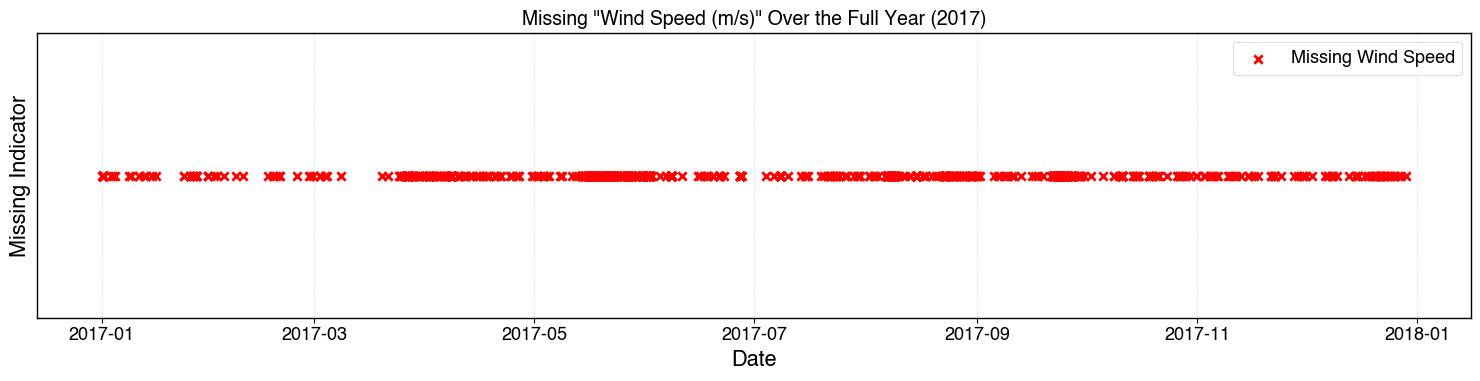

In [24]:
# Plot
plt.figure(figsize=(15, 4))
plt.scatter(missing_wind.index, [0]*len(missing_wind), color='red', marker='x', label='Missing Wind Speed')

plt.title('Missing "Wind Speed (m/s)" Over the Full Year (2017)')
plt.xlabel('Date')
plt.ylabel('Missing Indicator')
plt.yticks([])  # Hide Y-axis ticks
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Scrape and Baseline Analysis

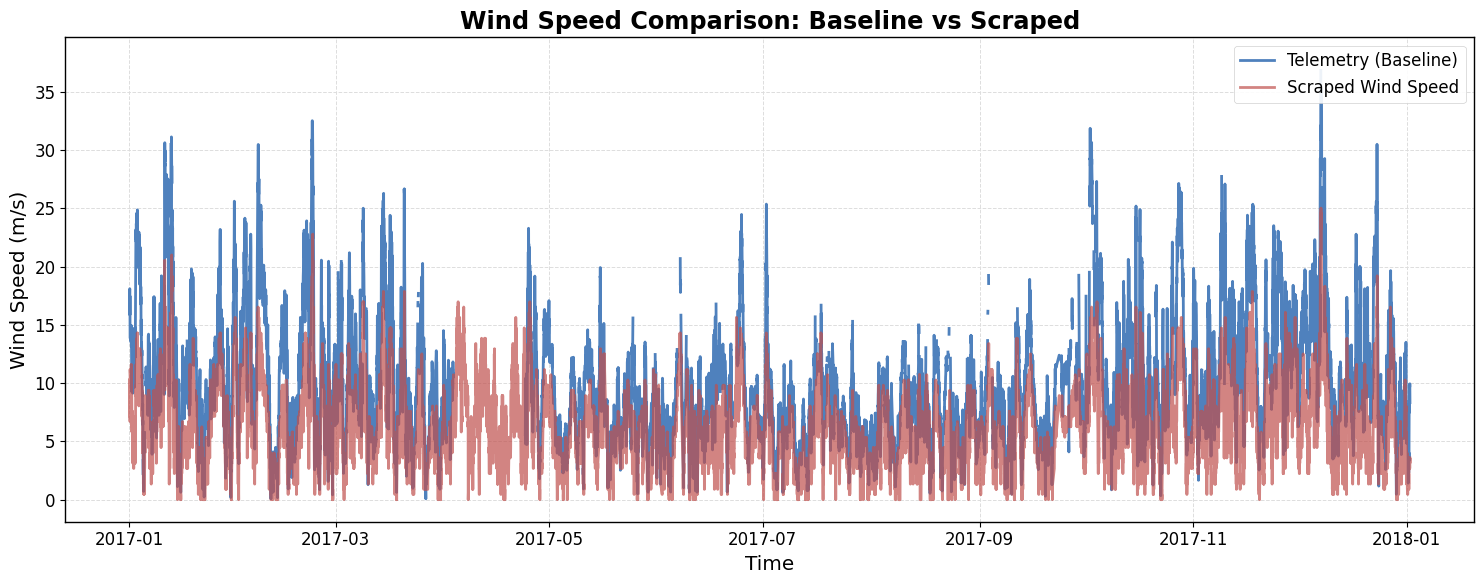

In [58]:
# Plot over time
plt.figure(figsize=(15, 6))

plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_baseline'], label='Telemetry (Baseline)', linewidth=2)
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_scraped'], label='Scraped Wind Speed', alpha=0.7)
# plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_monthly_scaled'], label='Corrected Wind Speed', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Comparison: Baseline vs Scraped')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

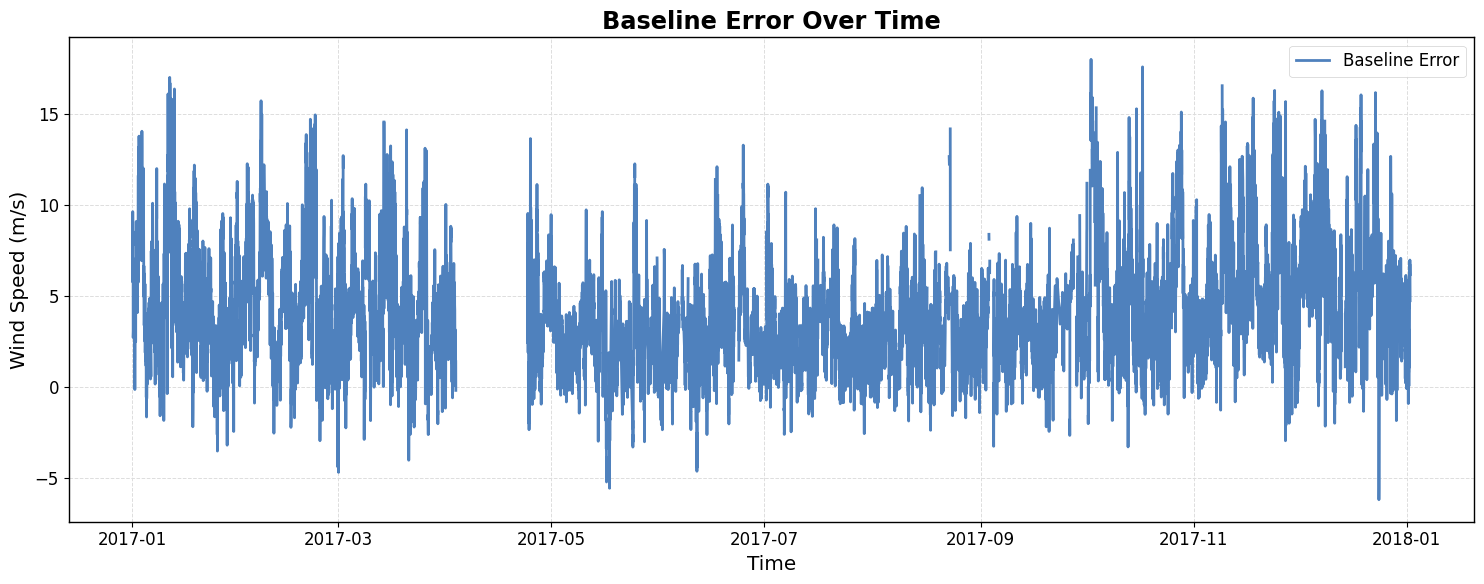

In [59]:
#baseline error
baseline_error = df_tt_wd['Wind_speed_baseline'] - df_tt_wd['Wind_speed_scraped']

#plot
plt.figure(figsize=(15, 6))
plt.plot(df_tt_wd['Timestamp'], baseline_error, label='Baseline Error', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Baseline Error Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Correlation Scraped-Baseline

In [60]:
# Calculation Correlation Between Wind Speed and Wind Speed Baseline
correlation = df_tt_wd['Wind_speed_scraped'].corr(df_tt_wd['Wind_speed_baseline'])
print("Correlation:", correlation)


Correlation: 0.842338187013438


## Scaling with Monthly Percentage Differences

In [61]:
# Calculate monthly means
monthly_means = df_tt_wd.groupby('Month')[['Wind_speed_scraped', 'Wind_speed_baseline']].mean()

# Calculate correction factors
monthly_means['correction_factor'] = monthly_means['Wind_speed_baseline'] / monthly_means['Wind_speed_scraped']

# Join the correction factor back to the main dataframe
df_tt_wd = df_tt_wd.merge(monthly_means['correction_factor'], on='Month', how='left')

# Apply the correction
df_tt_wd['Wind_speed_monthly_scaled'] = df_tt_wd['Wind_speed_scraped'] * df_tt_wd['correction_factor']

monthly_means.head(12)


Wind_speed_scraped  Wind_speed_baseline  correction_factor
Month                                                              
2017-01            7.024976            11.909933           1.695370
2017-02            6.836293            11.803518           1.726596
2017-03            6.335610            10.563270           1.667285
2017-04            7.347837            10.880955           1.480838
2017-05            5.313900             7.740323           1.456618
2017-06            5.667384             8.393286           1.480981
2017-07            4.662879             6.969608           1.494701
2017-08            4.550007             7.367241           1.619171
2017-09            5.563869             8.227088           1.478663
2017-10            6.947536            11.880759           1.710068
2017-11            7.600928            13.242516           1.742224
2017-12            6.491856            12.091605           1.862580

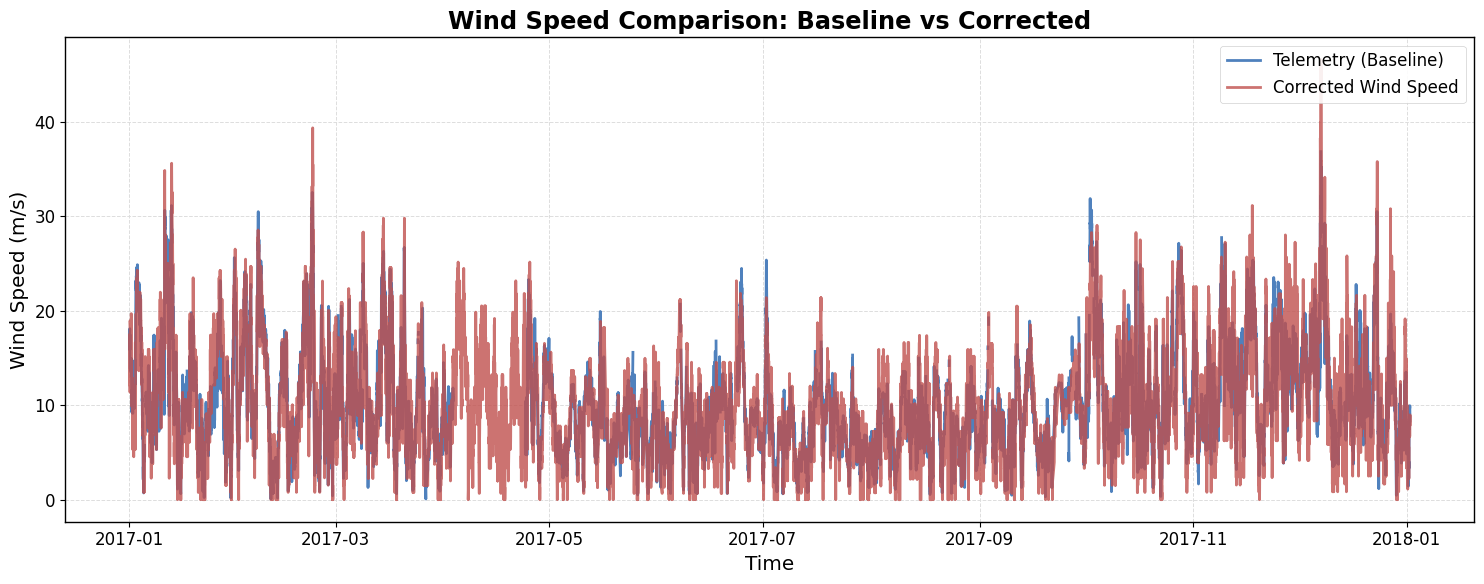

In [63]:
# Plot over time
plt.figure(figsize=(15, 6))

plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_baseline'], label='Telemetry (Baseline)', linewidth=2)
# plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_scraped'], label='Scraped Wind Speed', alpha=0.7)
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Wind_speed_monthly_scaled'], label='Corrected Wind Speed', alpha=0.8)

plt.xlabel('Time')
plt.ylabel('Wind Speed (m/s)')
plt.title('Wind Speed Comparison: Baseline vs Corrected')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

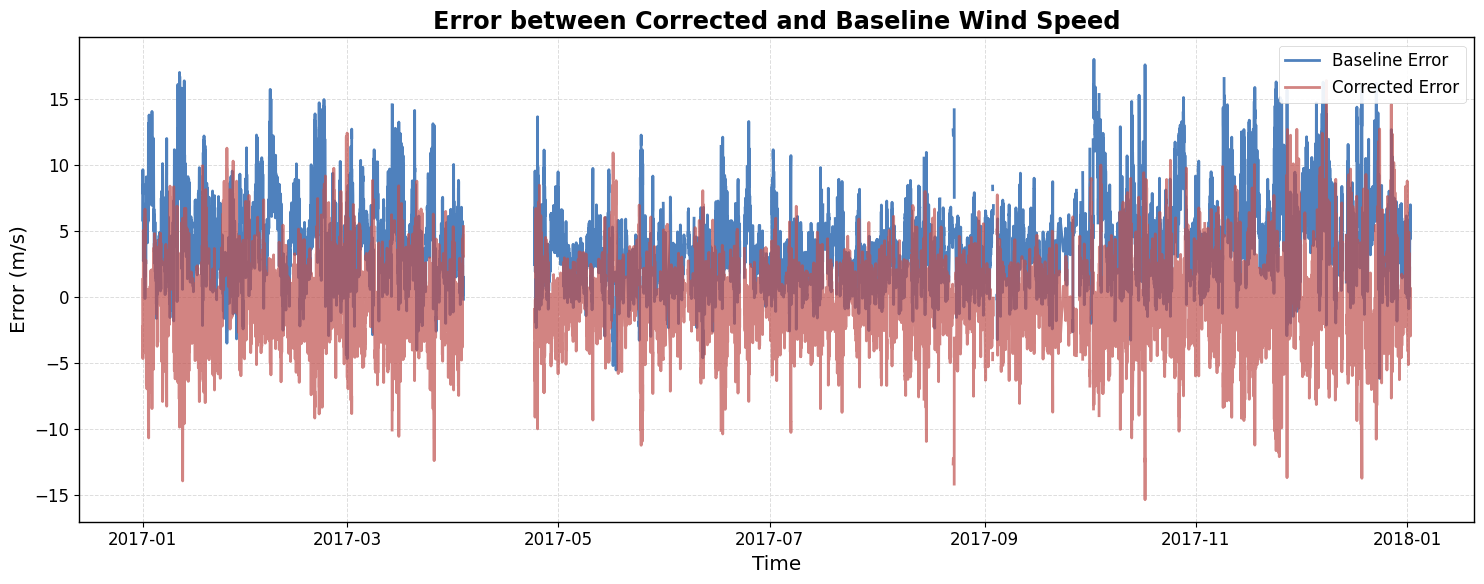

In [64]:
error = df_tt_wd['Wind_speed_monthly_scaled'] - df_tt_wd['Wind_speed_baseline']

# Plot the correction error and baseline error 
plt.figure(figsize=(15, 6))
plt.plot(df_tt_wd['Timestamp'],baseline_error, label='Baseline Error', linewidth=2)
plt.plot(df_tt_wd['Timestamp'], error, label='Corrected Error', linewidth=2, alpha=0.7)
plt.xlabel('Time')
plt.ylabel('Error (m/s)')
plt.title('Error between Corrected and Baseline Wind Speed')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Scale with Z-Scale

In [65]:
# I dont think its correct to scale with z-scale since it is not a normal distribution

# Energy Generated

$$
\begin{equation*} P(v)=\displaystyle \frac{1}{2}\rho Av^{3}C_{p}.\tag{1}\end{equation*}
$$

Where:

* $P$ = power output (in watts, W)
* $\rho$ = air density (in kg/m³), typically \~1.176 kg/m³ at at a height of 60 m above ground.
* $A$ = swept area of the rotor (in m²), $A = \pi r^2$
* $v$ = wind speed (in m/s)
* $C_p$ = power coefficient (efficiency), typically $\leq 0.59$ due to **Betz's limit**

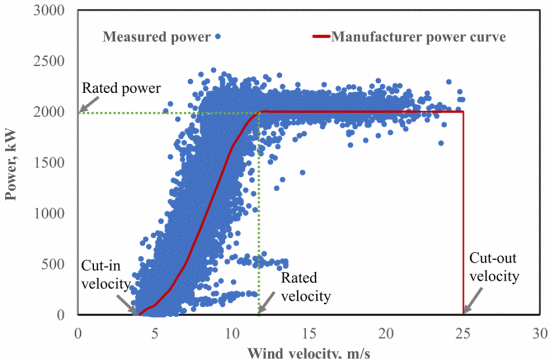

The output power is zero in Region 1 or in the range [0,$v_{ci}$ [. The cut-in speed, $v_{ci}$, is thus the minimal wind speed below which the output power is non-zero. The wind turbine must resist its own inertia to begin rotating the blades in that zone.

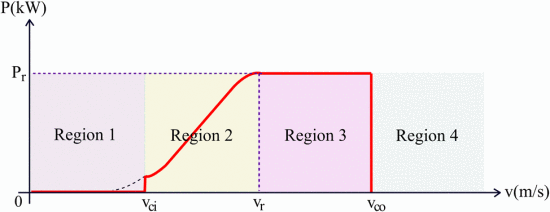

[Source](https://ieeexplore.ieee.org/document/10063743)

In [66]:
df_tt_wd.head()

Timestamp  Wind_speed_scraped  Wind_speed_baseline  \
0 2017-01-01 00:30:00               10.28            16.106667   
1 2017-01-01 01:00:00                9.39            16.380000   
2 2017-01-01 01:30:00                9.83            17.083333   
3 2017-01-01 02:00:00                7.15            16.800000   
4 2017-01-01 02:30:00                8.94            18.021739   

   Power_baseline    Month  Month_int  correction_factor  \
0      893.266667  2017-01          1            1.69537   
1      897.633333  2017-01          1            1.69537   
2      899.966667  2017-01          1            1.69537   
3      900.000000  2017-01          1            1.69537   
4      899.956522  2017-01          1            1.69537   

   Wind_speed_monthly_scaled  
0                  17.428404  
1                  15.919524  
2                  16.665487  
3                  12.121896  
4                  15.156608

In [ ]:
Curtailment is calculated using energy (kwh) not power (kw)

KwH -> but our data is in half hour 

so we multiply by 0.5

### Deriving Rotor Radius

In [67]:
# Constants
rho = 1.176  # air density in kg/m³
cp = 0.35    # power coefficient
pi = np.pi

# Only use data where baseline power is below setpoint
valid = (df_tt_wd['Power_baseline'] < 880) & (df_tt_wd['Power_baseline'] > 20)

# Use the corrected wind speed and power baseline
P = df_tt_wd.loc[valid, 'Power_baseline'] * 1000  # convert kW to W
v = df_tt_wd.loc[valid, 'Wind_speed_baseline']

# Avoid division by zero or very small wind speeds
safe = v > 0
P = P[safe]
v = v[safe]

# Calculate rotor radius and diameter
r = np.sqrt((2 * P) / (rho * pi * v**3 * cp))

print(f"Mean rotor radius: {r.mean()} m")
print(f"Standard deviation of rotor radius: {r.std()} m")
print(f"Min rotor radius: {r.min()} m")
print(f"Max rotor radius: {r.max()} m")





Mean rotor radius: 26.412538192413134 m
Standard deviation of rotor radius: 3.7379804123737346 m
Min rotor radius: 1.0293558587352127 m
Max rotor radius: 41.67598267128607 m


## Theoritical With Clipping

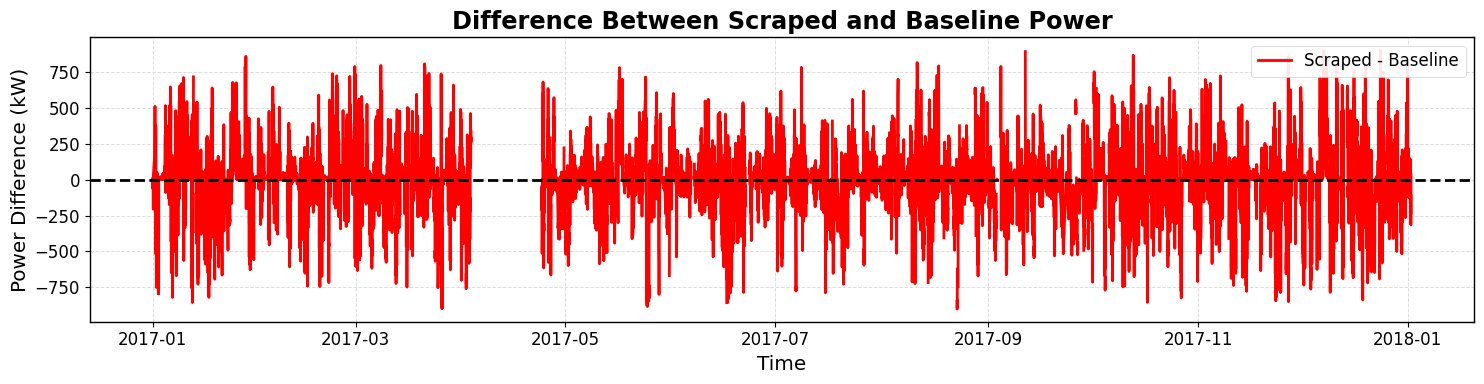

In [68]:
_r = r.mean()

def naive_power(v:float,rho:float=1.225, r:float = _r ,cp:float= 0.35) -> float:
    return 0.5 * rho * (np.pi * (r**2)) * (v**3) * cp / 1000
    
df_tt_wd['Potential_theoretical_energy'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: naive_power(v, r = _r))

#add cap to 900
df_tt_wd['Naive_Power_scraped'] = df_tt_wd['Potential_theoretical_energy'].clip(upper=900)

#visualize

df_tt_wd['Naive_Power_diff'] = df_tt_wd['Naive_Power_scraped'] - df_tt_wd['Power_baseline']

plt.figure(figsize=(15, 4))
plt.plot(df_tt_wd['Timestamp'], df_tt_wd['Naive_Power_diff'], color='red', label='Scraped - Baseline')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Power Difference (kW)')
plt.title('Difference Between Scraped and Baseline Power')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/9s/vnh0yrb52292pp21phjjlqpm0000gn/T/ipykernel_4582/2577792909.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  power_curve = df_tt_wd.groupby('Wind_speed_scaled_bin').agg({


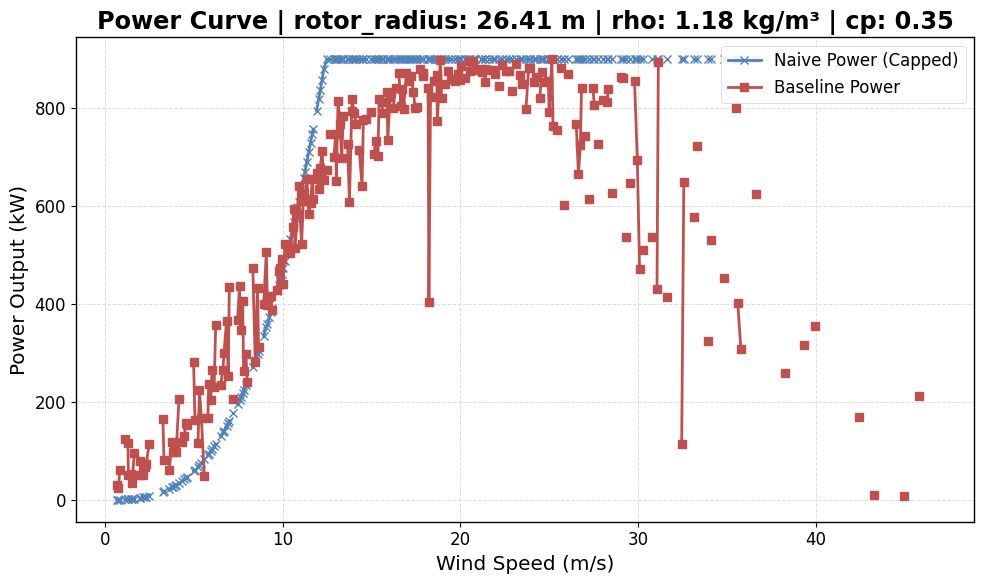

In [69]:
# Bin wind speed into intervals (e.g., every 0.5 m/s)
df_tt_wd['Wind_speed_scaled_bin'] = pd.cut(df_tt_wd['Wind_speed_monthly_scaled'], bins=np.arange(0, df_tt_wd['Wind_speed_monthly_scaled'].max()+0.1, 0.1))

# Group by wind speed bins and calculate mean power
power_curve = df_tt_wd.groupby('Wind_speed_scaled_bin').agg({
    'Wind_speed_monthly_scaled': 'mean',
    'Potential_theoretical_energy': 'mean',
    'Naive_Power_scraped': 'mean',
    'Power_baseline': 'mean'
}).reset_index()

plt.figure(figsize=(10, 6))
# plt.plot(power_curve['Wind_speed_monthly_scaled'], power_curve['Potential_theoretical_energy'], label='Naive Theoretical Power', marker='o')
plt.plot(power_curve['Wind_speed_monthly_scaled'], power_curve['Naive_Power_scraped'], label='Naive Power (Capped)', marker='x')
plt.plot(power_curve['Wind_speed_monthly_scaled'], power_curve['Power_baseline'], label='Baseline Power', marker='s')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title(f'Power Curve | rotor_radius: {r.mean():.2f} m | rho: {rho:.2f} kg/m³ | cp: {cp:.2f}')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [70]:
from sklearn.metrics import mean_squared_error,r2_score

# Only compare where both values are available (i.e., not NaN)
valid_mse = df_tt_wd[['Naive_Power_scraped', 'Power_baseline']].dropna()

mse_naive = mean_squared_error(valid_mse['Power_baseline'], valid_mse['Naive_Power_scraped'])
rmse_naive = np.sqrt(mse_naive)
r2_naive = r2_score(valid_mse['Power_baseline'], valid_mse['Naive_Power_scraped'])

print(f"Naive MSE: {mse_naive:.2f} kW²")
print(f"Naive RMSE: {rmse_naive:.2f} kW")
print(f"Naive R² Score: {r2_naive:.4f}")

Naive MSE: 49637.51 kW²
Naive RMSE: 222.79 kW
Naive R² Score: 0.5585


## Weibull Cumulative Distribution Power Output Model

$$
\begin{equation*} P(\nu)=P_r\left(1-e^{-\left(\frac{v-v_0}{c}\right)^3}\right),\tag{10}\end{equation*}
$$


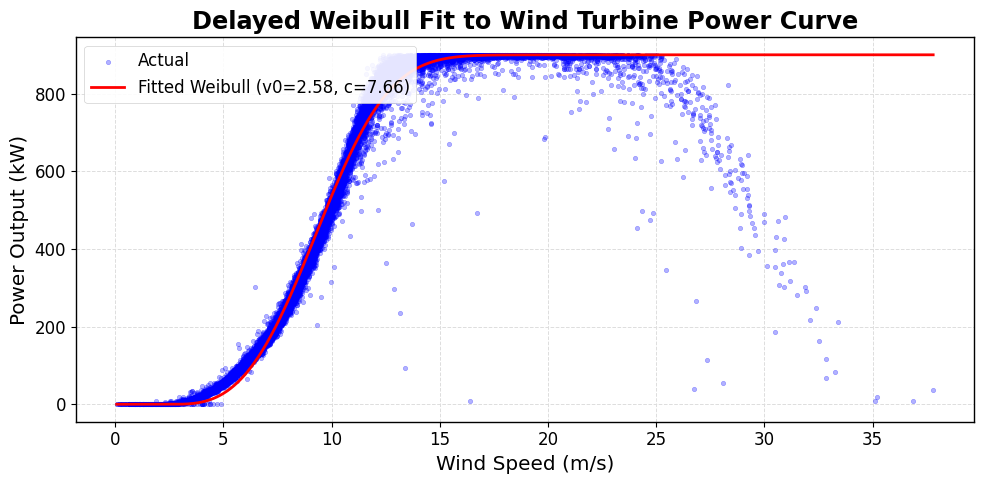

(np.float64(2.583001282770365), np.float64(7.664525041260357))

In [71]:
from scipy.optimize import curve_fit

def delayed_weibull(v:float, v0:float, c:float, pr:float):
    """
    Weibull model for wind speed distribution.
    
    Parameters:
    pr (float): Power rating of the turbine in kW. (or setpoint in our case i think)
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the Weibull distribution in m/s.
    
    Returns:
    float: Power output in kW.
    """
    v = np.asarray(v)
    power = np.zeros_like(v)
    mask = v > v0
    power[mask] = pr * (1 - np.exp(-((v[mask] - v0) / c) ** 3))
    return power

#remove nan values and convert to values
df_model = df_tt_wd.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])

# # filter out above 895 wind speed
# df_model = df_model[df_model['Wind_speed_baseline'] < 895]

wind = df_model['Wind_speed_baseline'].values
power = df_model['Power_baseline'].values


# Initial guesses for v0 and c
initial_guess = [2.7, 6.5]

# Fit curve
popt, pcov = curve_fit(lambda v, v0, c: delayed_weibull(v, v0, c, pr=900), wind, power, p0=initial_guess)


# Predicted values using fitted parameters
v0_fit, c_fit = popt
predicted_power = delayed_weibull(wind, v0_fit, c_fit, pr=900)

# Plot actual vs fitted curve
v_sorted = np.sort(wind)


predicted_sorted = delayed_weibull(v_sorted, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Wind Turbine Power Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

### Using Our Wind data

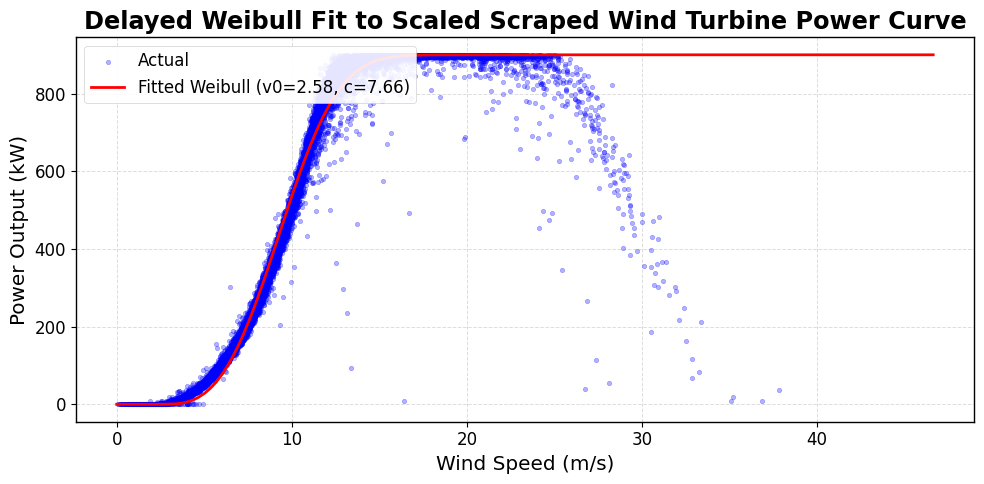

In [72]:
sorted_scaled_wind = np.sort(df_tt_wd['Wind_speed_monthly_scaled'].dropna())
# Predicted values using fitted parameters
predicted_sorted = delayed_weibull(sorted_scaled_wind, v0_fit, c_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(sorted_scaled_wind, predicted_sorted, color='red', label=f'Fitted Weibull (v0={v0_fit:.2f}, c={c_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('Delayed Weibull Fit to Scaled Scraped Wind Turbine Power Curve')
plt.legend(loc = 'upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
# Calculate the Weibull power curve using the fitted parameters
df_tt_wd['Weibull_Power'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: delayed_weibull(v, v0_fit, c_fit, pr=900))

Weilbull Mean Absolute Error (MAE): 147.3472394054607
Weilbull Root Mean Squared Error (RMSE): 222.25203119446147
Weilbull R² Score: 0.5606101800680148


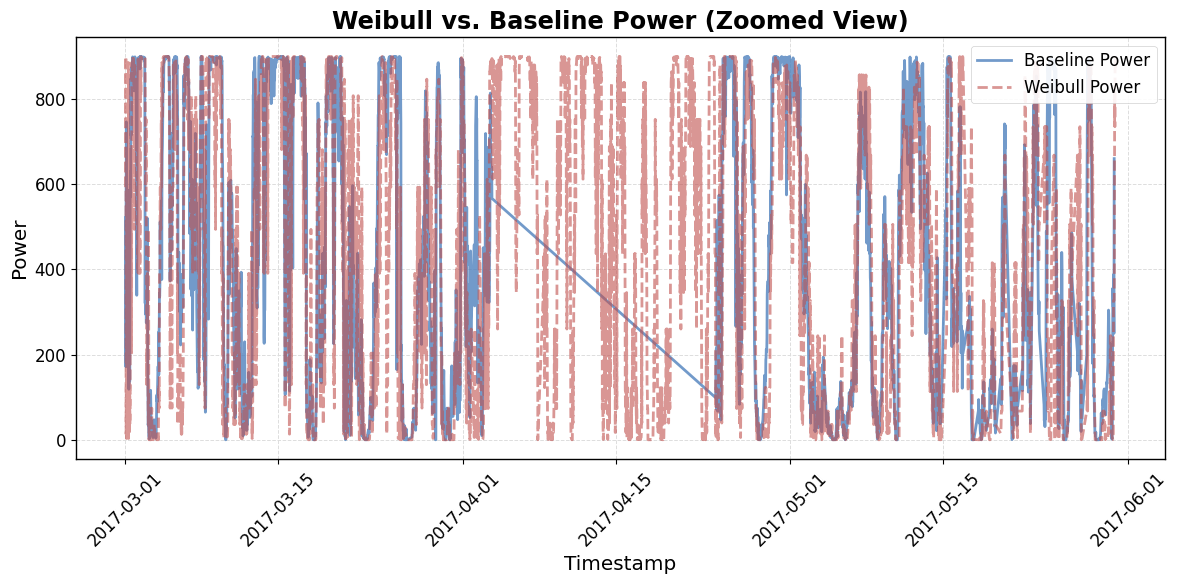

In [74]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

valid_stats = df_tt_wd[['Weibull_Power', 'Power_baseline']].dropna()
mae_wb = mean_absolute_error(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])
rmse_wb = root_mean_squared_error(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])
r2_wb = r2_score(valid_stats['Power_baseline'], valid_stats['Weibull_Power'])

print("Weilbull Mean Absolute Error (MAE):", mae_wb)
print("Weilbull Root Mean Squared Error (RMSE):", rmse_wb)
print("Weilbull R² Score:", r2_wb)


df_zoom = df_tt_wd[(df_tt_wd['Timestamp'] >= '2017-03-01') & (df_tt_wd['Timestamp'] <= '2017-05-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Timestamp', y='Power_baseline', data=df_zoom, label='Baseline Power', linestyle='-', alpha=0.8)
sns.lineplot(x='Timestamp', y='Weibull_Power', data=df_zoom, label='Weibull Power', linestyle='--', alpha=0.6)
plt.title('Weibull vs. Baseline Power (Zoomed View)')
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.xticks(rotation=45)
# set legend position
plt.legend(loc='upper right') 
plt.tight_layout()
plt.show()


/var/folders/9s/vnh0yrb52292pp21phjjlqpm0000gn/T/ipykernel_4582/968289054.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([df_tt_wd['Power_baseline'].min(), df_tt_wd['Power_baseline'].max()],


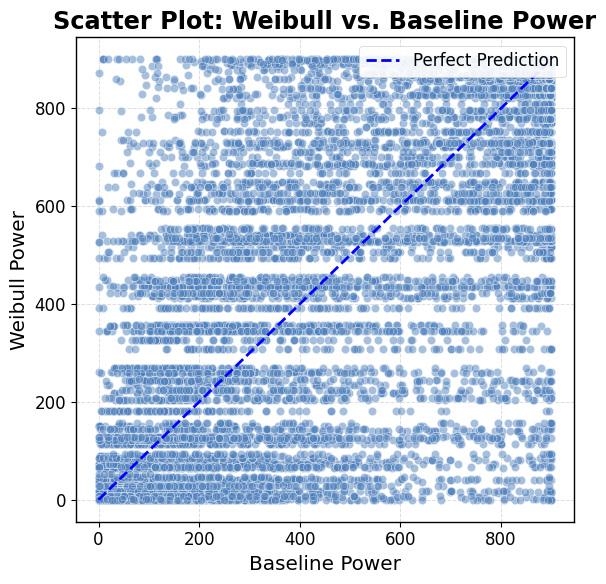

In [75]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x='Power_baseline', y='Weibull_Power', data=df_tt_wd, alpha=0.5)
plt.plot([df_tt_wd['Power_baseline'].min(), df_tt_wd['Power_baseline'].max()],
         [df_tt_wd['Power_baseline'].min(), df_tt_wd['Power_baseline'].max()],
         'r--', color = 'blue',label='Perfect Prediction')
plt.title('Scatter Plot: Weibull vs. Baseline Power')
plt.xlabel('Baseline Power')
plt.ylabel('Weibull Power')
plt.legend()
plt.tight_layout()
plt.show()


## 3PL

$$
\begin{equation*} P(\nu)=P_{r}\displaystyle \frac{1}{1+e^{-\gamma(\nu-v_{0})^{3}}},\tag{12}\end{equation*}
$$

/var/folders/9s/vnh0yrb52292pp21phjjlqpm0000gn/T/ipykernel_4582/3595162123.py:14: RuntimeWarning: overflow encountered in exp
  return pr * (1 / (1 + np.exp(-gamma * (v - v0)**3)))


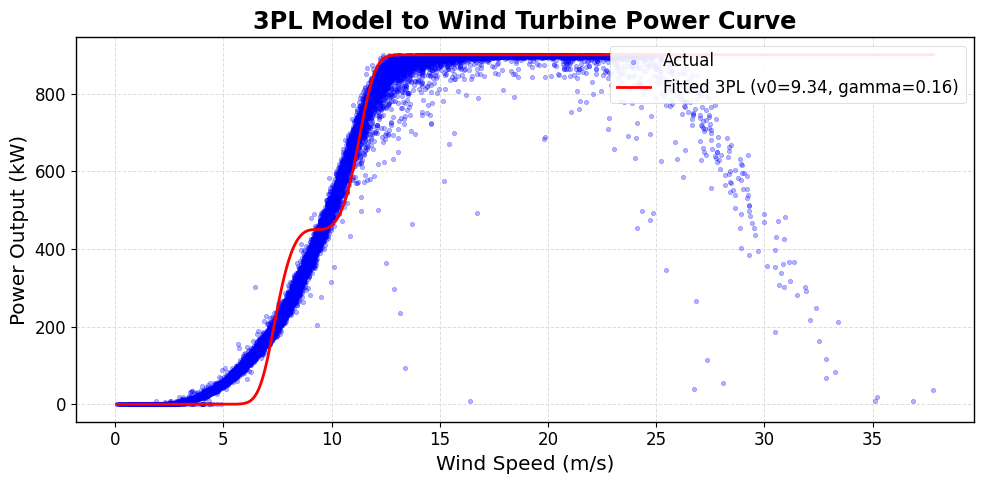

(np.float64(9.335692373869865), np.float64(7.664525041260357))

In [76]:
def three_pl(v, v0, gamma, pr):
    """
    Logistic model for wind speed distribution.
    
    Parameters:
    v (float): Wind speed in m/s.
    v0 (float): Scale parameter of the logistic distribution in m/s.
    gamma (float): Shape parameter of the logistic distribution.
    pr (float): Power rating of the turbine in kW.
    
    Returns:
    float: Power output in kW.
    """
    return pr * (1 / (1 + np.exp(-gamma * (v - v0)**3)))

#remove nan values and convert to values
df_model = df_tt_wd.dropna(subset=['Wind_speed_baseline', 'Power_baseline'])
wind = df_model['Wind_speed_baseline'].values
power = df_model['Power_baseline'].values


# Initial guesses for v0 and gamma
initial_guess = [1, 2]

# Fit curve
popt, pcov = curve_fit(lambda v, v0, gamma: three_pl(v, v0, gamma, pr=900), wind, power, p0=initial_guess)


# Predicted values using fitted parameters
v0_fit, g_fit = popt
predicted_power = three_pl(wind, v0_fit, g_fit, pr=900)

# Plot actual vs fitted curve
v_sorted = np.sort(wind)


predicted_sorted = three_pl(v_sorted, v0_fit, g_fit, pr=900)

plt.figure(figsize=(10, 5))
plt.scatter(wind, power, alpha=0.3, label='Actual', color='blue', s=10)
plt.plot(v_sorted, predicted_sorted, color='red', label=f'Fitted 3PL (v0={v0_fit:.2f}, gamma={g_fit:.2f})')
plt.xlabel('Wind Speed (m/s)')
plt.ylabel('Power Output (kW)')
plt.title('3PL Model to Wind Turbine Power Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

v0_fit, c_fit

3PL Mean Absolute Error (MAE): 159.44644411696268
3PL Root Mean Squared Error (RMSE): 236.74507916062308
3PL R² Score: 0.5014365524763966


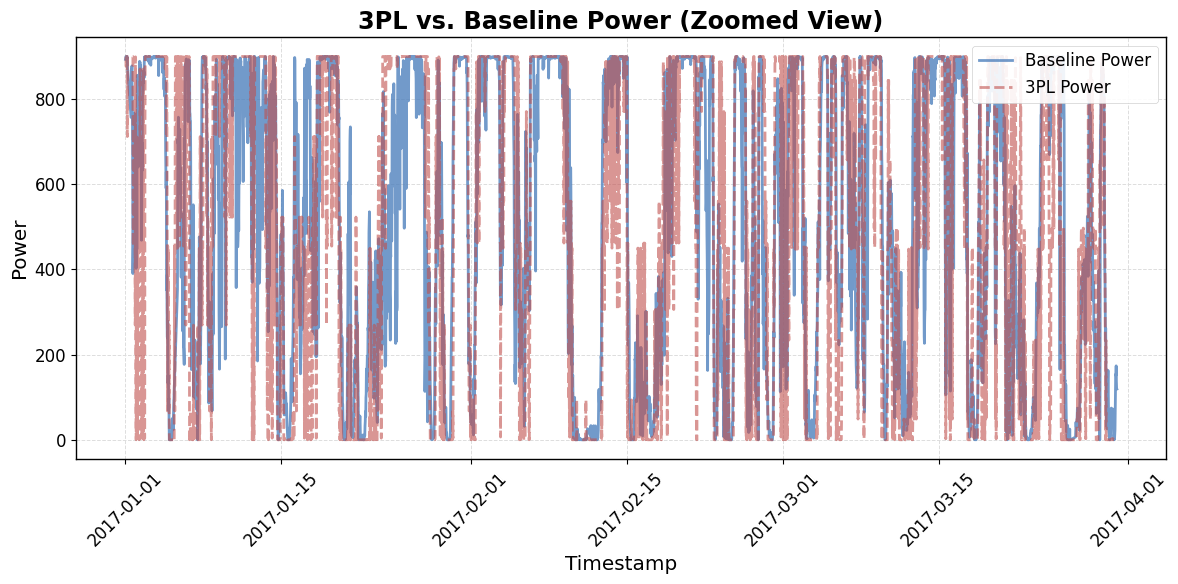

In [77]:
df_tt_wd['3PL_Power'] = df_tt_wd['Wind_speed_monthly_scaled'].apply(lambda v: three_pl(v, v0_fit, g_fit, pr=900))


valid_stats = df_tt_wd[['3PL_Power', 'Power_baseline']].dropna()
mae_3pl = mean_absolute_error(valid_stats['Power_baseline'], valid_stats['3PL_Power'])
rmse_3pl = root_mean_squared_error(valid_stats['Power_baseline'], valid_stats['3PL_Power'])
r2_3pl = r2_score(valid_stats['Power_baseline'], valid_stats['3PL_Power'])

print("3PL Mean Absolute Error (MAE):", mae_3pl)
print("3PL Root Mean Squared Error (RMSE):", rmse_3pl)
print("3PL R² Score:", r2_3pl)


df_zoom = df_tt_wd[(df_tt_wd['Timestamp'] >= '2017-01-01') & (df_tt_wd['Timestamp'] <= '2017-03-31')]

plt.figure(figsize=(12, 6))
sns.lineplot(x='Timestamp', y='Power_baseline', data=df_zoom, label='Baseline Power', linestyle='-', alpha=0.8)
sns.lineplot(x='Timestamp', y='3PL_Power', data=df_zoom, label='3PL Power', linestyle='--', alpha=0.6)
plt.title('3PL vs. Baseline Power (Zoomed View)')
plt.xlabel('Timestamp')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [78]:
df_tt_wd.to_csv(PROCESSED_DATASET / 'Turbine_telemetry_power_models_v1.csv', index=False)

df_tt_wd.head()


Timestamp  Wind_speed_scraped  Wind_speed_baseline  \
0 2017-01-01 00:30:00               10.28            16.106667   
1 2017-01-01 01:00:00                9.39            16.380000   
2 2017-01-01 01:30:00                9.83            17.083333   
3 2017-01-01 02:00:00                7.15            16.800000   
4 2017-01-01 02:30:00                8.94            18.021739   

   Power_baseline    Month  Month_int  correction_factor  \
0      893.266667  2017-01          1            1.69537   
1      897.633333  2017-01          1            1.69537   
2      899.966667  2017-01          1            1.69537   
3      900.000000  2017-01          1            1.69537   
4      899.956522  2017-01          1            1.69537   

   Wind_speed_monthly_scaled  Potential_theoretical_energy  \
0                  17.428404                   2487.236733   
1                  15.919524                   1895.546994   
2                  16.665487                   2174.694882   
3                  12.121896                    836.865963   
4                  15.156608                   1635.875828   

   Naive_Power_scraped  Naive_Power_diff Wind_speed_scaled_bin  Weibull_Power  \
0           900.000000          6.733333          (17.4, 17.5]     899.371249   
1           900.000000          2.366667          (15.9, 16.0]     895.362966   
2           900.000000          0.033333          (16.6, 16.7]     898.178475   
3           836.865963        -63.134037          (12.1, 12.2]     769.065192   
4           900.000000          0.043478          (15.1, 15.2]     889.114144   

    3PL_Power  
0  900.000000  
1  900.000000  
2  900.000000  
3  870.702911  
4  900.000000

## Compare Three Approaches

In [79]:
comparison_df = pd.DataFrame({
    "Model": ["Naive", "Weibull", "3PL"],
    "MAE": [np.nan,mae_wb, mae_3pl],
    "RMSE": [rmse_naive,rmse_wb, rmse_3pl],
    "R²": [r2_naive,r2_wb, r2_3pl]
})

comparison_df

Model         MAE        RMSE        R²
0    Naive         NaN  222.794763  0.558462
1  Weibull  147.347239  222.252031  0.560610
2      3PL  159.446444  236.745079  0.501437

Weibull function appear to be the better for modelling the wind turbine power curve.

In [84]:
df_tt_wd.head(1)

Timestamp  Wind_speed_scraped  Wind_speed_baseline  \
0 2017-01-01 00:30:00               10.28            16.106667   

   Power_baseline    Month  Month_int  correction_factor  \
0      893.266667  2017-01          1            1.69537   

   Wind_speed_monthly_scaled  Potential_theoretical_energy  \
0                  17.428404                   2487.236733   

   Naive_Power_scraped  Naive_Power_diff Wind_speed_scaled_bin  Weibull_Power  \
0                900.0          6.733333          (17.4, 17.5]     899.371249   

   3PL_Power  
0      900.0

# Filling Missing Data

In [ ]:
df_combined = pd.merge(
    df_rd[['Timestamp', 'Demand_mean_kw', 'N_households']],
    df_tt_wd[['Timestamp', 'Wind_speed_scraped', 'Power_baseline','Wind_speed_monthly_scaled', 'Weibull_Power' ]],
    how='left',
    on='Timestamp'
)

#check what date is missing

missing_data = df_combined[df_combined['Wind_speed_monthly_scaled'].isna()]


Timestamp  Demand_mean_kw  N_households  Wind_speed_scraped  \
0     2017-01-01 00:00:00        0.220106          5428                 NaN   
11    2017-01-01 05:30:00        0.121022          5429                 NaN   
12    2017-01-01 06:00:00        0.128810          5429                 NaN   
13    2017-01-01 06:30:00        0.135618          5429                 NaN   
14    2017-01-01 07:00:00        0.144163          5429                 NaN   
...                   ...             ...           ...                 ...   
17216 2017-12-25 15:00:00        0.455567         11835                 NaN   
17227 2017-12-25 20:30:00        0.295383         11830                 NaN   
17263 2017-12-26 14:30:00        0.320695         10734                 NaN   
17311 2017-12-27 14:30:00        0.301709         10734                 NaN   
17372 2017-12-28 21:00:00        0.357289         10734                 NaN   

       Power_baseline  Wind_speed_monthly_scaled  Weibull_Power  
0                 NaN                        NaN            NaN  
11                NaN                        NaN            NaN  
12                NaN                        NaN            NaN  
13                NaN                        NaN            NaN  
14                NaN                        NaN            NaN  
...               ...                        ...            ...  
17216             NaN                        NaN            NaN  
17227             NaN                        NaN            NaN  
17263             NaN                        NaN            NaN  
17311             NaN                        NaN            NaN  
17372             NaN                        NaN            NaN  

[987 rows x 7 columns]

# Curtailment

## Join Demand data with Processed Turbine Telemetry+Weather Data 

In [47]:
# join rd with df_tt_wd

df_tt_wd_rd = pd.merge(
    df_rd[['Timestamp', 'Demand_mean_kw','N_households']],
    df_tt_wd[['Timestamp', 'Wind_speed_monthly_scaled', 'Power_baseline', 'Weibull_Power', '3PL_Power']],
    how='inner',
    on='Timestamp'
)

df_tt_wd_rd['Timestamp'] = pd.to_datetime(df_tt_wd_rd['Timestamp'])

df_tt_wd_rd.head()

    

Timestamp  Demand_mean_kw  N_households  \
0 2017-01-01 00:30:00        0.205945          5429   
1 2017-01-01 01:00:00        0.189090          5429   
2 2017-01-01 01:30:00        0.173118          5429   
3 2017-01-01 02:00:00        0.159051          5429   
4 2017-01-01 02:30:00        0.147656          5429   

   Wind_speed_monthly_scaled  Power_baseline  Weibull_Power   3PL_Power  
0                  17.428404      893.266667     899.371249  900.000000  
1                  15.919524      897.633333     895.362966  900.000000  
2                  16.665487      899.966667     898.178475  900.000000  
3                  12.121896      900.000000     769.065192  870.702911  
4                  15.156608      899.956522     889.114144  900.000000

In [48]:
df_tt_wd_rd['Demand_mean_kw'].max()

np.float64(0.509661820699204)

## Curtailment Formula

$$
\text{Curtailment} = \text{Actual Generated Power} - (\text{Demand} + \text{Export})
$$

In [49]:
n_wind_turbines = 8

df_curtailment = pd.DataFrame({
    'Timestamp': df_tt_wd_rd['Timestamp'],
    'Date': df_tt_wd_rd['Timestamp'].dt.date,
    'Month_int': df_tt_wd_rd['Timestamp'].dt.month,
    'Generated_power': df_tt_wd_rd['Weibull_Power']*n_wind_turbines,
    'Demand_per_household': df_tt_wd_rd['Demand_mean_kw'],
    'N_households': df_tt_wd_rd['N_households'],
    'Demand_power': df_tt_wd_rd['Demand_mean_kw']*df_tt_wd_rd['N_households']
})
df_curtailment['Energy_kwh_per_household'] = df_curtailment['Demand_per_household'] * 0.5 # 30 min
df_curtailment['Energy_kwh_total'] = df_curtailment['Demand_per_household'] * df_curtailment['N_households'] * 0.5
df_curtailment['Curtailment_baseline'] = df_curtailment['Generated_power'] - df_curtailment['Demand_power']
df_curtailment['Generated_power_smooth'] = df_curtailment['Generated_power'].rolling(window=6, center=True).mean()
df_curtailment['Demand_power_smooth'] = df_curtailment['Demand_power'].rolling(window=6, center=True).mean()
df_curtailment['Curtailment_baseline_smooth'] = df_curtailment['Curtailment_baseline'].rolling(window=6, center=True).mean()


print(f"Max Generated Power: {df_curtailment['Generated_power'].max()}")
print(f"Max Demand Power: {df_curtailment['Demand_power'].max()}")
print(f"Max Curtailment: {df_curtailment['Curtailment_baseline'].max()}")
print(f"Min Generated Power: {df_curtailment['Generated_power'].min()}")
print(f"Min Demand Power: {df_curtailment['Demand_power'].min()}")
print(f"Min Curtailment: {df_curtailment['Curtailment_baseline'].min()}")
print(f"Columns: {df_curtailment.columns}")

Max Generated Power: 7200.0
Max Demand Power: 9688.176000000001
Max Curtailment: 6610.530000000001
Min Generated Power: 0.0
Min Demand Power: 568.0880000000001
Min Curtailment: -9688.176000000001
Columns: Index(['Timestamp', 'Date', 'Month_int', 'Generated_power',
       'Demand_per_household', 'N_households', 'Demand_power',
       'Energy_kwh_per_household', 'Energy_kwh_total', 'Curtailment_baseline',
       'Generated_power_smooth', 'Demand_power_smooth',
       'Curtailment_baseline_smooth'],
      dtype='object')


## Comparing Generated, Demand and Curtailment

## Orkney Reports Summary

---

### Income & Cost of Living

- Orkney has **lower than average income** compared to the Scottish average (£34,619).
  - Average income in Orkney’s Isles is **~£10,000 below the Scottish average**.
- **Higher living costs** due to geographic isolation:
  - It costs on average **20% more** to live in rural island areas.
  - Costs rise to **~30% more** for smaller remote islands like Orkney’s outer isles.
  - Increased costs affect:
    - Food shopping
    - Transport
    - Energy bills

- Implications:
  - **Significant fuel poverty** risk, especially in outer islands.
  - Even Mainland Orkney households face affordability challenges.

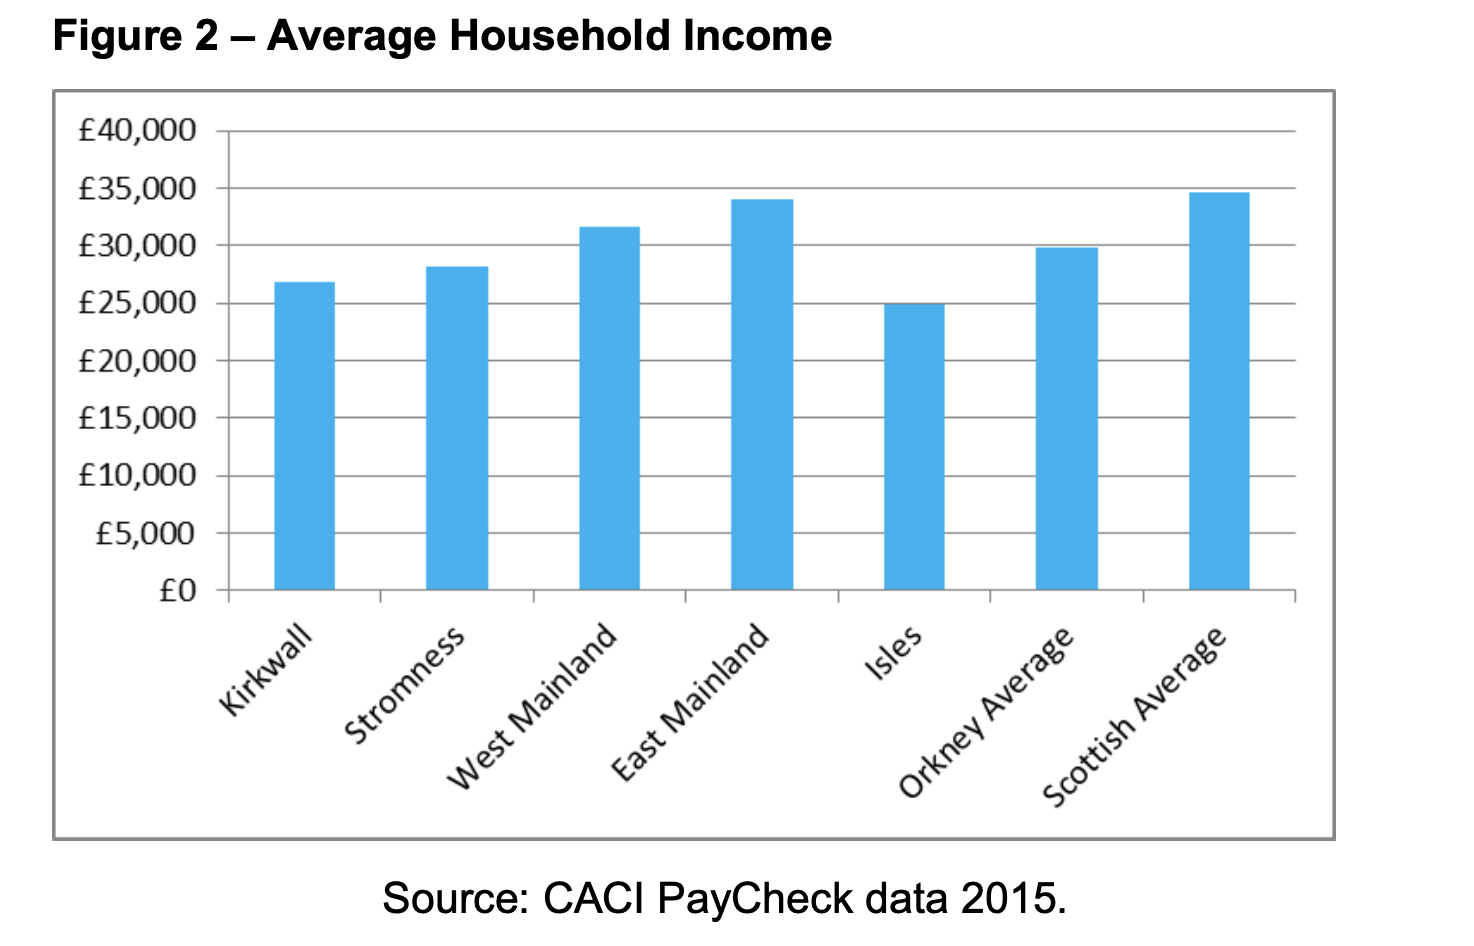

---

### Heating Types

- **41% of households** use **electric heating** (per 2011 Census).
- **36% of households** use **oil heating**.
- Other findings:
  - Affordable Warmth Survey estimates **25–30%** oil use.
- **Electricity consumption**:
  - Orkney average: **8,193 kWh/year**
  - Scotland average: **4,465 kWh/year**
  - UK average: **4,092 kWh/year**
- **Energy cost comparison**:
  - Mains gas: ~3.34p per kWh
  - North Scotland electricity: ~15.61p per kWh

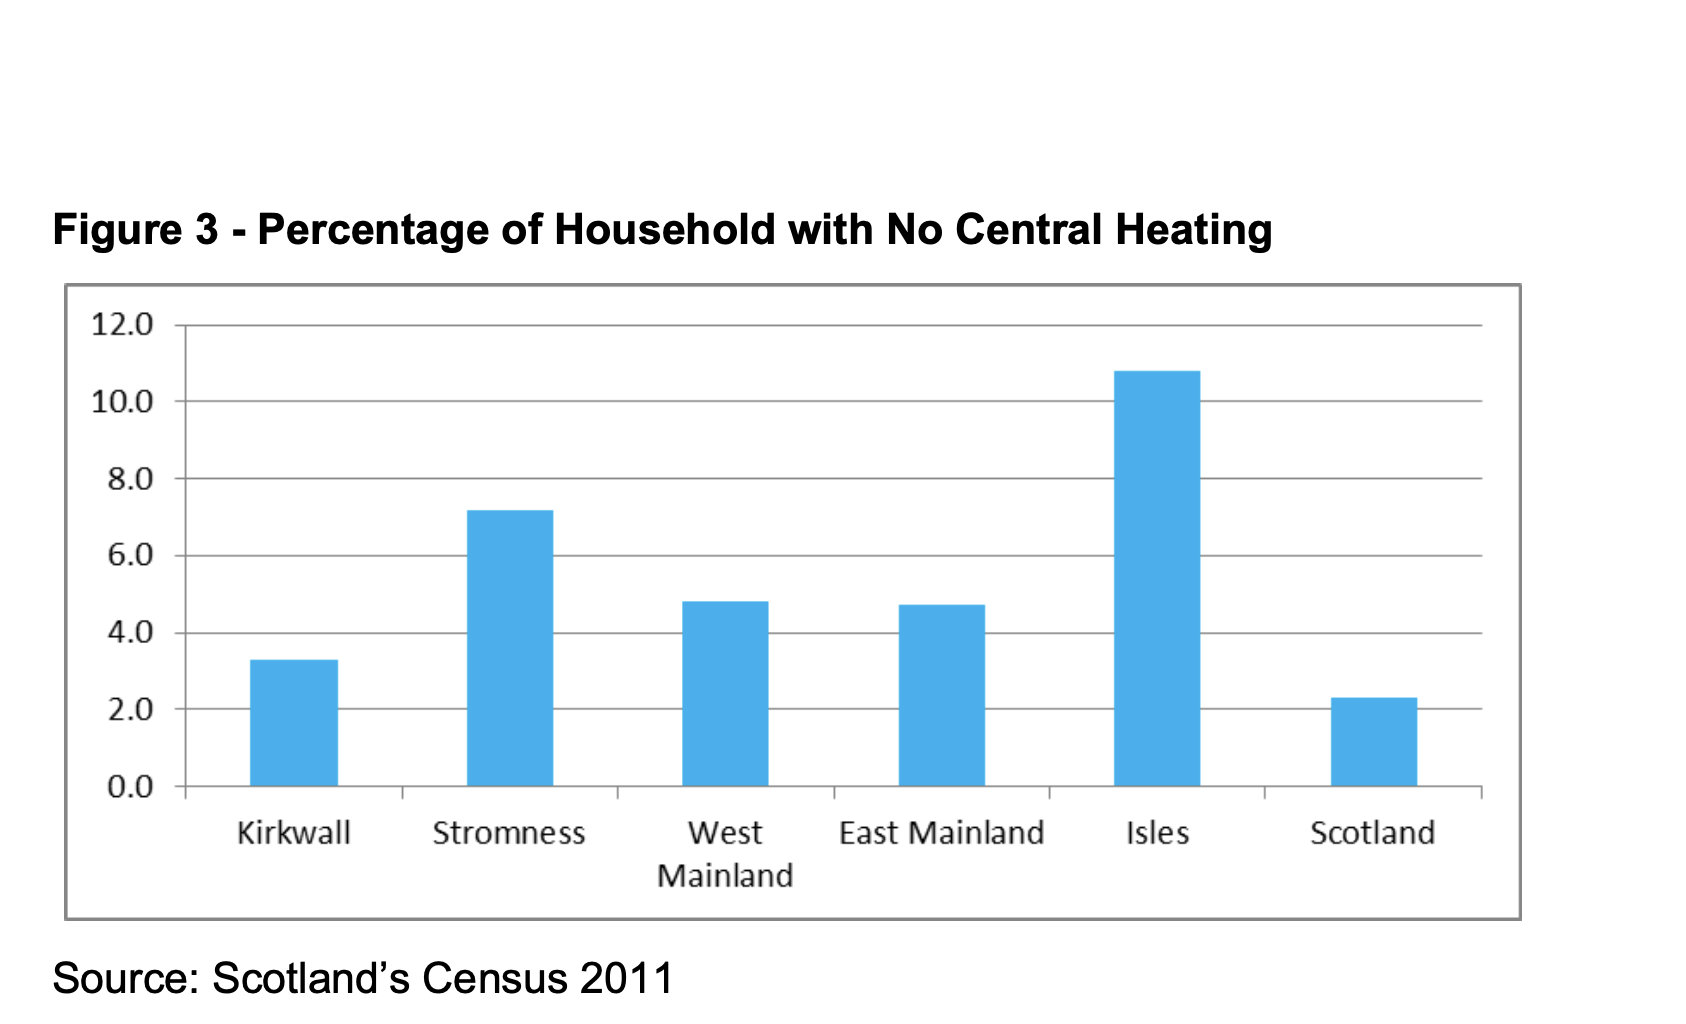

---

### Housing Stock & Energy Efficiency

- Age and condition of homes directly impact fuel poverty.
- Key stats:
  - **~25%** of housing is **pre-1919** (low energy efficiency).
  - Majority of new development occurred **post-1983** (better efficiency).
  - Older stock is mostly in the **private rented sector**.
  - **Kirkwall**, **West Mainland**, and **East Mainland**:
    - Less than 30% pre-1919 housing
    - More than 45% of homes are post-1983 (owner-occupied or social housing)
  - **Isles**: Nearly **50% of homes are pre-1919**

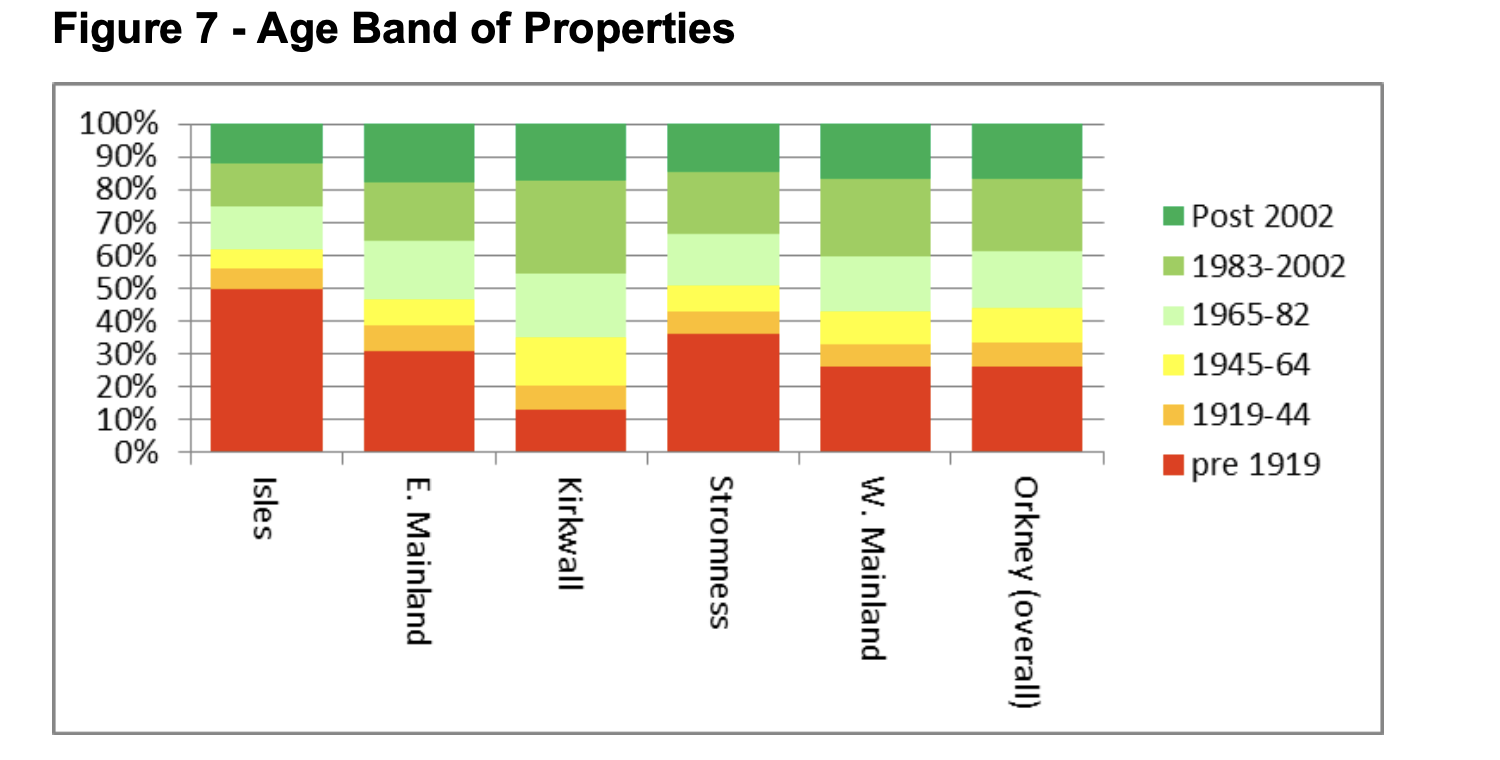

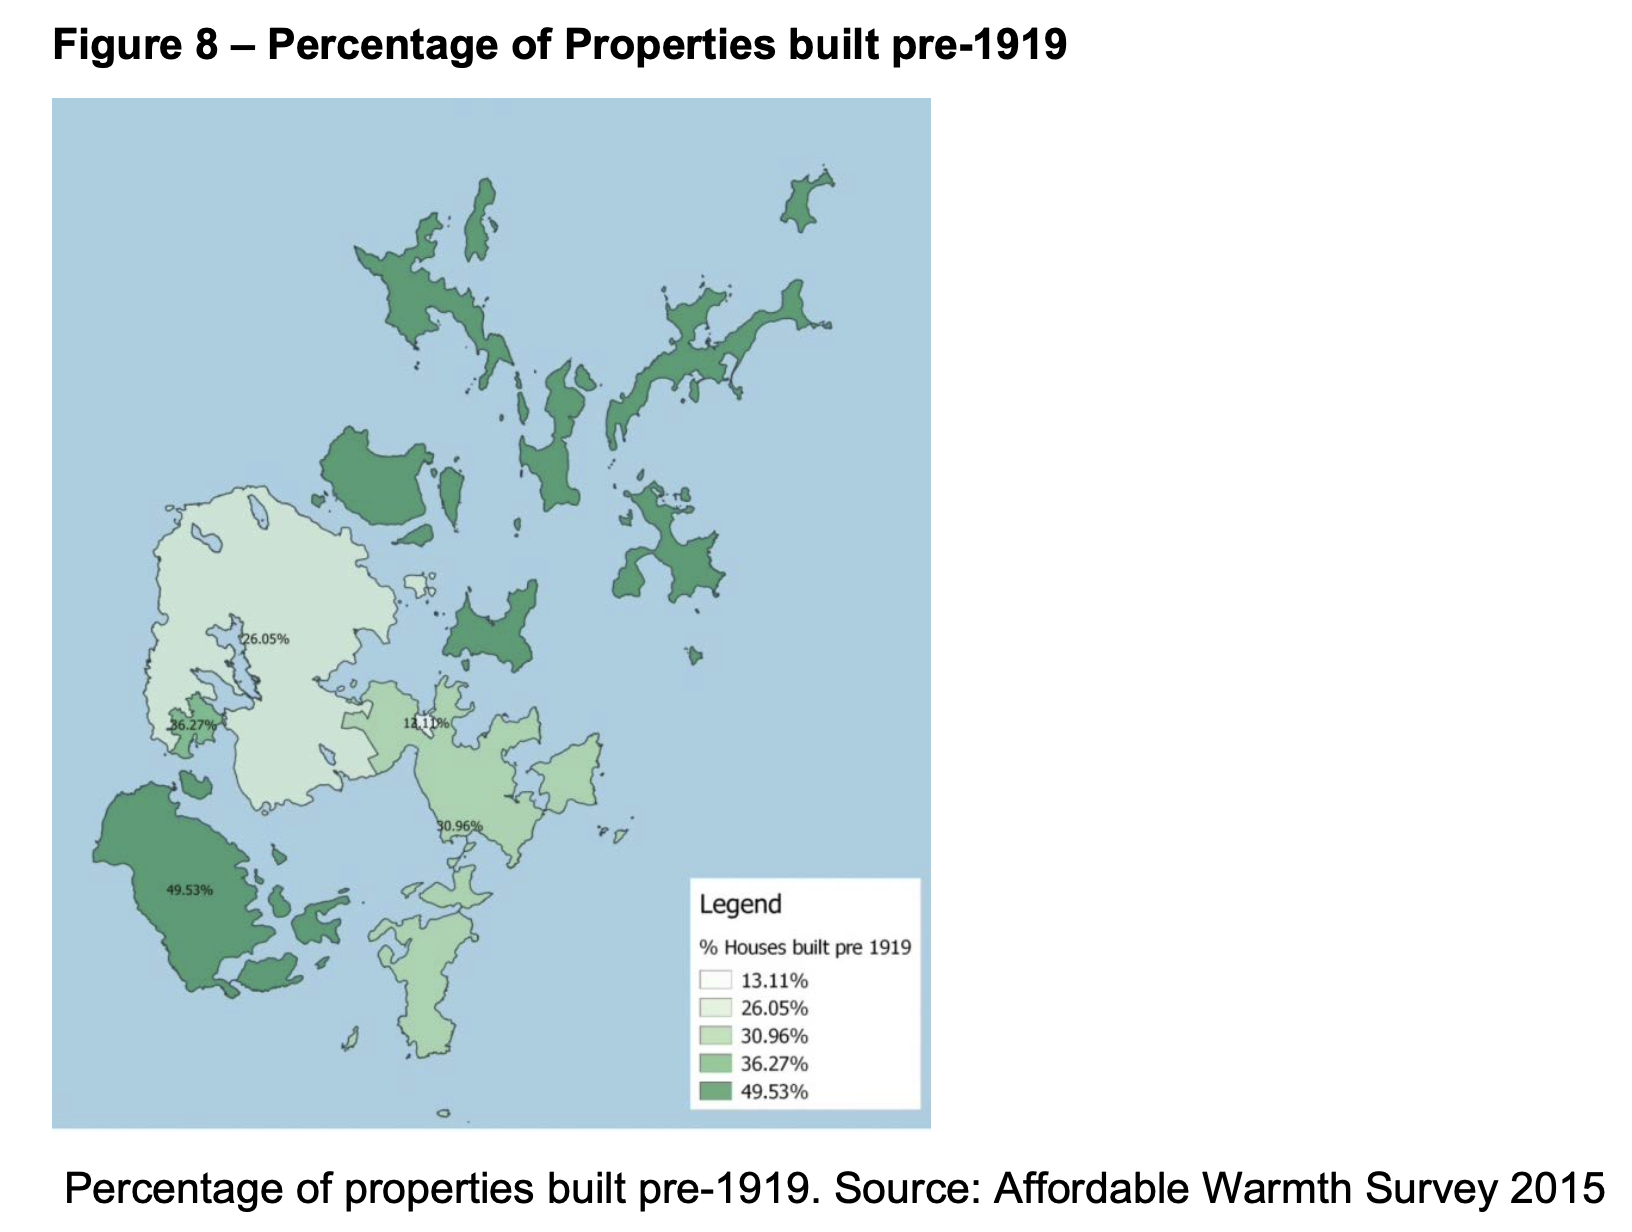

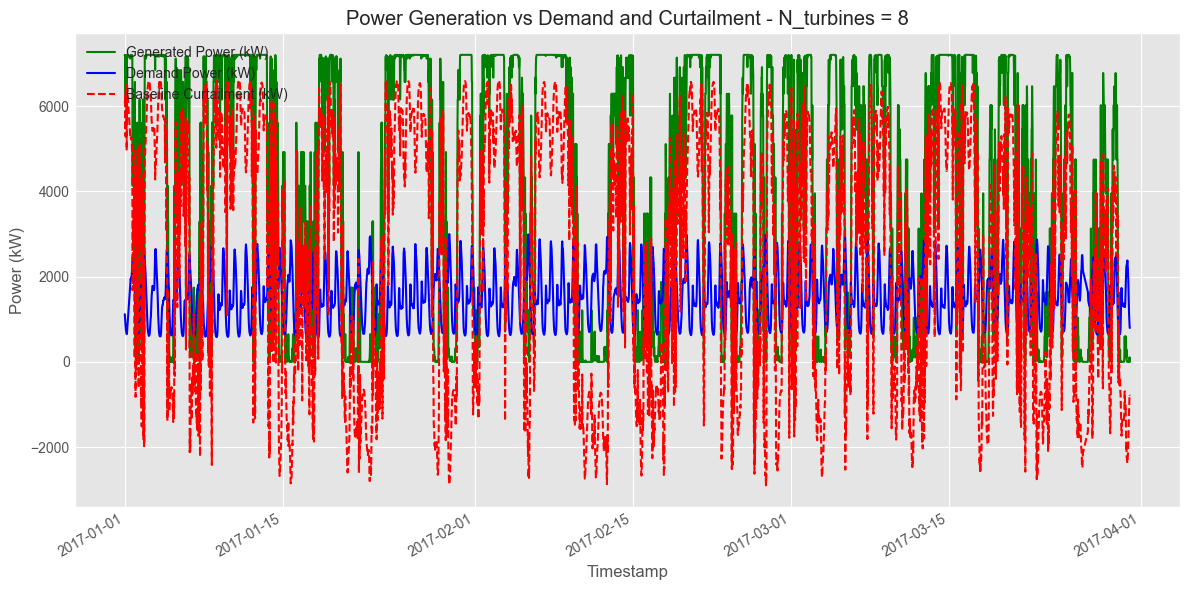

In [336]:
df_curtailment_zoom = df_curtailment[(df_curtailment['Timestamp'] >= '2017-01-01') & (df_curtailment['Timestamp'] <= '2017-03-31')]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Generated Power
ax.plot(df_curtailment_zoom['Timestamp'], df_curtailment_zoom['Generated_power'],
        label='Generated Power (kW)', color='green')

# Demand Power
ax.plot(df_curtailment_zoom['Timestamp'], df_curtailment_zoom['Demand_power'],
        label='Demand Power (kW)', color='blue')

# Curtailment
ax.plot(df_curtailment_zoom['Timestamp'], df_curtailment_zoom['Curtailment_baseline'],
        label='Baseline Curtailment (kW)', color='red', linestyle='--')

# Labels and formatting
ax.set_title(f'Power Generation vs Demand and Curtailment - N_turbines = {n_wind_turbines}')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Power (kW)')
ax.legend(loc='upper left')
ax.grid(True)
fig.autofmt_xdate()  # Still rotates date labels nicely

# Save the plot
plt.tight_layout()
# plt.savefig(FIGURES_PATH / "curtailment_plot.png", dpi=300)
plt.show()
